In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
import ast
import yaml
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import read_files
from util import count_edge_crossings
from util import bfs

# Analysis of answers for `transpose_prompts`


## Load and clean the answers

In [4]:
answer_dir = os.path.join("answers", "transpose_prompts3")

In [5]:
has_copy_code = []
no_copy_code = []

for answer_file in sorted(os.listdir(answer_dir)):
    answer_file_path = os.path.join(answer_dir, answer_file)

    answer_str = open(answer_file_path, "r").read().strip()

    if "Copy code" in answer_str:
        has_copy_code.append(answer_file)
    else:
        no_copy_code.append(answer_file)

print("Has copy code: ", len(has_copy_code))
print("No copy code: ", len(no_copy_code))

Has copy code:  1
No copy code:  206


The files that contain the stirng "Copy code" contain the answer formatted in a code block. These are likely to contain a potentially appropriate answer to the query.
Files containing only unstructured text are less likely to contain valid answers and will be analyzed separately.

In [6]:
answers = {}
missed = {}

for answer_file in sorted(has_copy_code):
    answer_file_path = os.path.join(answer_dir, answer_file)
    answer_str = open(answer_file_path, "r").read().strip()

    # print(answer_file)
    # print(answer_str)

    answer_str = answer_str.split("Copy code")[1].strip()

    if "ranks =" in answer_str:
        answer_str = answer_str.split("ranks =")[1].strip()
        answer_str = answer_str.split("}")[0].strip()
        answer_str = answer_str + "}"

    try:
        answer_dict = yaml.safe_load(answer_str)
    except:
        try:
            answer_dict = json.loads(answer_str)
        except:
            try:
                answer_dict = ast.literal_eval(answer_str)
            except:
                missed[answer_file] = answer_str
                continue
    
    # print(answer_dict)
    answers[answer_file] = answer_dict
    # print()
    # break

print("Missed: ", len(missed))
print("Answers: ", len(answers))

Missed:  0
Answers:  1


Let's now look at the other files.

In [7]:
additional_answers = {}
additional_missed = {}

for answer_file in sorted(no_copy_code):
    answer_file_path = os.path.join(answer_dir, answer_file)
    answer_str = open(answer_file_path, "r").read().strip()
    
    if "ranks =" in answer_str:
        answer_str = answer_str.split("ranks =")[1].strip()
        answer_str = answer_str.split("}")[0].strip()
        answer_str = answer_str + "}"

    try:
        answer_dict = yaml.safe_load(answer_str)
    except:
        try:
            answer_dict = json.loads(answer_str)
        except:
            try:
                answer_dict = ast.literal_eval(answer_str)
            except:
                additional_missed[answer_file] = answer_str
                continue
    
    # print(answer_dict)
    additional_answers[answer_file] = answer_dict

print("Additional missed: ", len(additional_missed))
print("Additional answers: ", len(additional_answers))

Additional missed:  5
Additional answers:  201


We can now merge the parsed answers together.

In [8]:
answers.update(additional_answers)
missed.update(additional_missed)

# Safety check
non_dict = []
for k,v in answers.items():
    if type(v) != dict:
        print("{} does not have a dict : {}".format(k, v))
        non_dict.append((k,v))

for (k,v) in non_dict:
    del answers[k]
    missed[k] = v

print("Total missed: ", len(missed))
print("Total answers: ", len(answers))

Total missed:  5
Total answers:  202


## Load and clean the prompts

In [9]:
queries_dir = os.path.join("queries", "transpose_prompts3")

In [10]:
queries = {}

for query_file in sorted(os.listdir(queries_dir)):
    queries[query_file] = {}
    query_file_path = os.path.join(queries_dir, query_file)

    query_str = open(query_file_path, "r").read().strip()

    query_edges = query_str.split("edges = ")[1]
    query_edges = query_edges.split("\n")[0].strip()
    query_edges = ast.literal_eval(query_edges)

    query_ranks = query_str.split("ranks = ")[1]
    query_ranks = query_ranks.split("\n\n")[0].strip()
    query_ranks = query_ranks.split("\n")
    # From each substring remove "Layer " at the 
    # beginning and add "," at the end
    query_ranks = [r[6:].strip() + "," for r in query_ranks]
    query_ranks = "".join(query_ranks)
    query_ranks = "{" + query_ranks[:-1] + "}"
    query_ranks = ast.literal_eval(query_ranks)
    
    queries[query_file]["edges"] = query_edges
    queries[query_file]["ranks"] = query_ranks

print("Number of queries: ", len(queries))

Number of queries:  207


## Safety check: all nodes are there

In [11]:
all_nodes_queries = {}
for query_file, query_dict in queries.items():
    all_nodes_queries[query_file] = set()
    for edge in query_dict["edges"]:
        all_nodes_queries[query_file].add(edge[0])
        all_nodes_queries[query_file].add(edge[1])

# Print the number of nodes in the graphs of each query
all_nodes_orig_number = [len(all_nodes_queries[query_file]) for query_file in all_nodes_queries]
print("\nUnique number of nodes in the graphs of each query:")
print(np.unique(all_nodes_orig_number, return_counts=True))

all_nodes_answers = {}
for answer_file, answer_dict in answers.items():
    all_nodes_answers[answer_file] = set()
    for rank, nodes in answer_dict.items():
        for node in nodes:
            all_nodes_answers[answer_file].add(node)

# Print the number of nodes in the graphs of each answer
all_nodes_answer_number = [len(all_nodes_answers[answer_file]) for answer_file in all_nodes_answers]
print("\nUnique number of nodes in the graphs of each answer:")
print(np.unique(all_nodes_answer_number, return_counts=True))

correct_nodes_answers = {}
incorrect_nodes_answers = {}
for answer_file, answer_dict in answers.items():
    answer_nodes = all_nodes_answers[answer_file]
    query_nodes = all_nodes_queries[answer_file]

    if answer_nodes == query_nodes:
        correct_nodes_answers[answer_file] = answer_dict
    else:
        incorrect_nodes_answers[answer_file] = answer_dict

print("\nCorrect nodes answers: ", len(correct_nodes_answers))
print("Incorrect nodes answers: ", len(incorrect_nodes_answers))


Unique number of nodes in the graphs of each query:
(array([10, 11]), array([ 79, 128]))

Unique number of nodes in the graphs of each answer:
(array([10, 11]), array([ 79, 123]))

Correct nodes answers:  201
Incorrect nodes answers:  1


We can now take a look at the different alterations in those graphs whose number of nodes is different than it should be.

In [12]:
increased_nodes_answers = {}
decreased_nodes_answers = {}

for answer_file, answer_dict in incorrect_nodes_answers.items():
    answer_nodes = all_nodes_answers[answer_file]
    query_nodes = all_nodes_queries[answer_file]

    if len(answer_nodes) > len(query_nodes):
        increased_nodes_answers[answer_file] = answer_dict
    else:
        decreased_nodes_answers[answer_file] = answer_dict

print("\nIncreased nodes answers: ", len(increased_nodes_answers))
print("Decreased nodes answers: ", len(decreased_nodes_answers))


Increased nodes answers:  0
Decreased nodes answers:  1


In [13]:
WRONG_FORMAT = -1
MISSING_NODES = -2
EXTRA_NODES = -3

In [14]:
results = []
for i, query in enumerate(queries):


    c = count_edge_crossings(queries[query]["edges"], queries[query]["ranks"])
    if query in correct_nodes_answers:
        c2 = count_edge_crossings(queries[query]["edges"], answers[query])
    elif query in increased_nodes_answers:
        c2 = EXTRA_NODES
    elif query in decreased_nodes_answers:
        c2 = MISSING_NODES
    else:
        c2 = WRONG_FORMAT
    # print("original crossings: ", c, "new crossings: ", c2)
    results.append({
        "query": query,
        "original_crossings": c,
        "new_crossings": c2,
    })


    # break

results_df = pd.DataFrame.from_dict(results)

In [15]:
results_df

,query,original_crossings,new_crossings
0,grafo10064.39.txt,0.0,1.0
1,grafo10093.98.txt,0.0,2.0
2,grafo10149.95.txt,0.0,3.0
3,grafo10163.93.txt,0.0,0.0
4,grafo10547.94.txt,0.0,0.0
...,...,...,...
202,grafo9797.80.txt,0.0,-1.0
203,grafo983.19.txt,2.0,-1.0
204,grafo9873.35.txt,0.0,-1.0
205,grafo9931.39.txt,0.0,-1.0


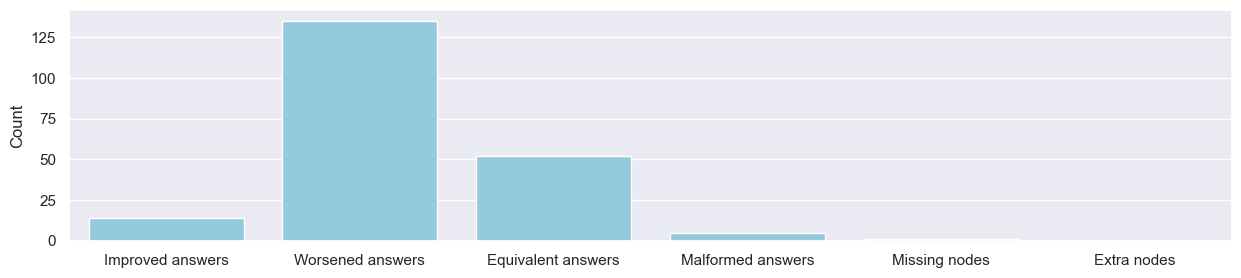

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Generate some sample data as a dictionary
data = {}

# Count the number of entries for which new_crossings is positive and new_crossings < original_crossings
improved_answers = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] < x["original_crossings"], results))
data["Improved answers"] = len(improved_answers)

# Count the number of entries for which new_crossings is positive and new_crossings > original_crossings
data["Worsened answers"] = len(list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] > x["original_crossings"], results)))

# Count the number of entries for which new_crossings is positive and new_crossings == original_crossings
data["Equivalent answers"] = len(list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] == x["original_crossings"], results)))

# Count the number of malformed answers
data["Malformed answers"] = len(list(filter(lambda x: x["new_crossings"] == WRONG_FORMAT, results)))

# Count the number of answers with missing nodes
data["Missing nodes"] = len(list(filter(lambda x: x["new_crossings"] == MISSING_NODES, results)))

# Count the number of answers with extra nodes
data["Extra nodes"] = len(list(filter(lambda x: x["new_crossings"] == EXTRA_NODES, results)))

# Convert the dictionary to a Pandas DataFrame for plotting
df = pd.DataFrame.from_dict(data, orient='index', columns=['Value'])

sns.set(rc={'figure.figsize':(15,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=df.index, y='Value', data=df, color='skyblue')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [17]:
for ans in improved_answers:
    q = ans["query"]
    print("original ranks: ", queries[q]["ranks"])
    print("original edges: ", queries[q]["edges"])
    print("response ranks:", answers[q])
    print("\n\n")
    # break
    

original ranks:  {0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]}
original edges:  [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]
response ranks: {0: [0], 1: [3, 1], 2: [9, 8, 2, 7, 4, 6], 3: [5]}



original ranks:  {0: [0], 1: [4, 5, 9, 10], 2: [1, 2, 3, 7], 3: [6, 8]}
original edges:  [(0, 4), (4, 1), (1, 6), (0, 5), (5, 2), (7, 1), (8, 2), (4, 2), (3, 9), (9, 0), (10, 9), (10, 1), (10, 7), (10, 0)]
response ranks: {0: [0], 1: [4, 10, 5, 9], 2: [1, 7, 4, 2], 3: [6, 8], 4: [3]}



original ranks:  {0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]}
original edges:  [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]
response ranks: {0: [0], 1: [3, 1], 2: [8, 9, 4, 2, 7, 6], 3: [5]}



original ranks:  {0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]}
original edges:  [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4

In [18]:
def visualize_graph(ranks:dict, edges:list):
    import networkx as nx

    plt.figure(figsize=(14, 5))

    edges_out_of_node = {}
    for edge in edges:
        if edge[0] not in edges_out_of_node:
            edges_out_of_node[edge[0]] = []
        edges_out_of_node[edge[0]].append(edge[1])
        if edge[1] not in edges_out_of_node:
            edges_out_of_node[edge[1]] = []
        edges_out_of_node[edge[1]].append(edge[0])

    G = nx.Graph()
    for (layer_n, layer) in ranks.items():
        for node in layer:
            G.add_node(node, layer=layer_n)

    pos = nx.multipartite_layout(G, subset_key="layer")
    nodes_draw = nx.draw_networkx_nodes(G, pos)
    node_labels_dict = nx.draw_networkx_labels(G, pos, font_color='white', font_weight='bold',)

    for (layer_n, layer) in ranks.items():
        for node in layer:
            if node in edges_out_of_node:
                for edge_target in edges_out_of_node[node]:
                    G.add_edge(node, edge_target)
    edges_draw = nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    plt.show()
        

Original graph:
{0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]} [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]


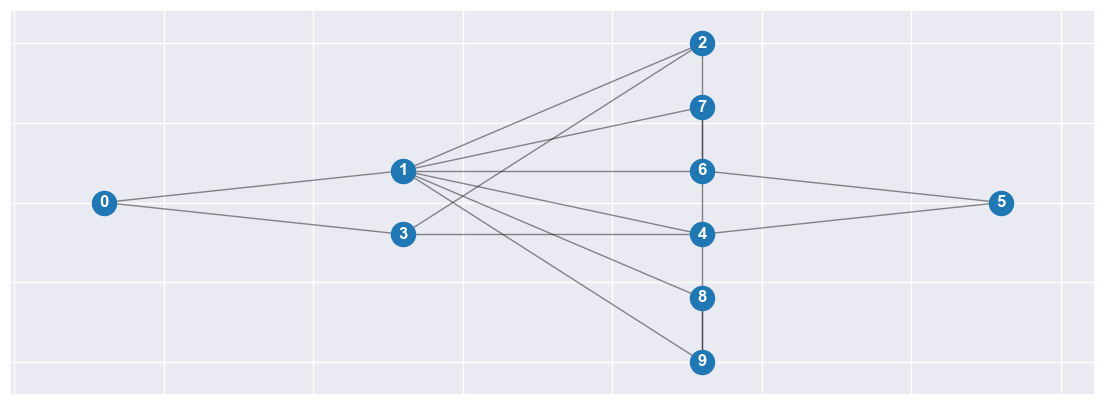

Answer graph:
{0: [0], 1: [3, 1], 2: [9, 8, 2, 7, 4, 6], 3: [5]}


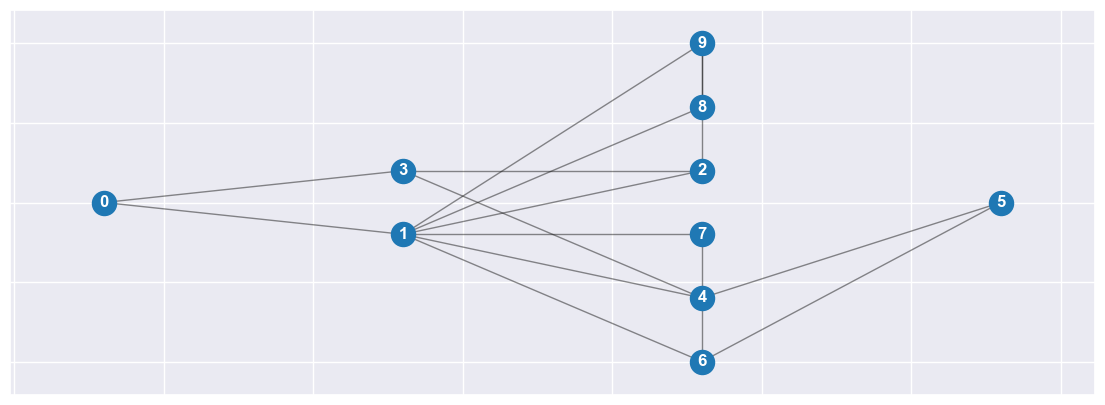




Original graph:
{0: [0], 1: [4, 5, 9, 10], 2: [1, 2, 3, 7], 3: [6, 8]} [(0, 4), (4, 1), (1, 6), (0, 5), (5, 2), (7, 1), (8, 2), (4, 2), (3, 9), (9, 0), (10, 9), (10, 1), (10, 7), (10, 0)]


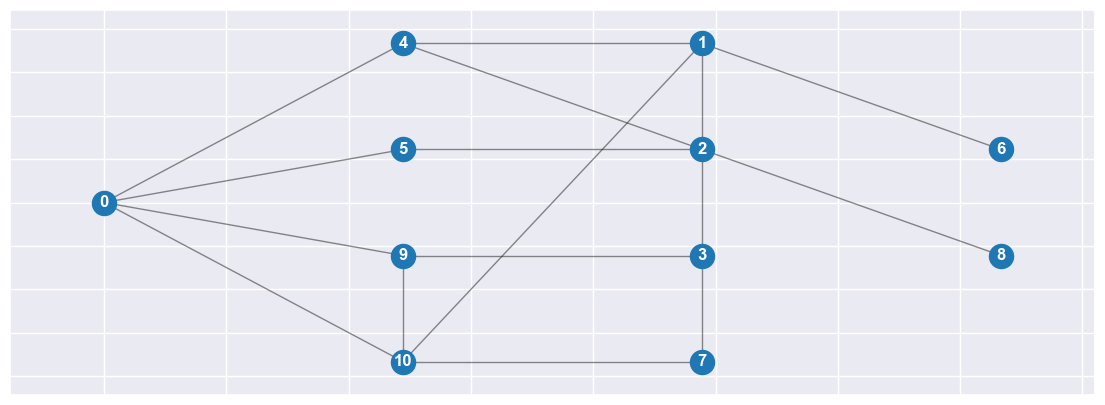

Answer graph:
{0: [0], 1: [4, 10, 5, 9], 2: [1, 7, 4, 2], 3: [6, 8], 4: [3]}


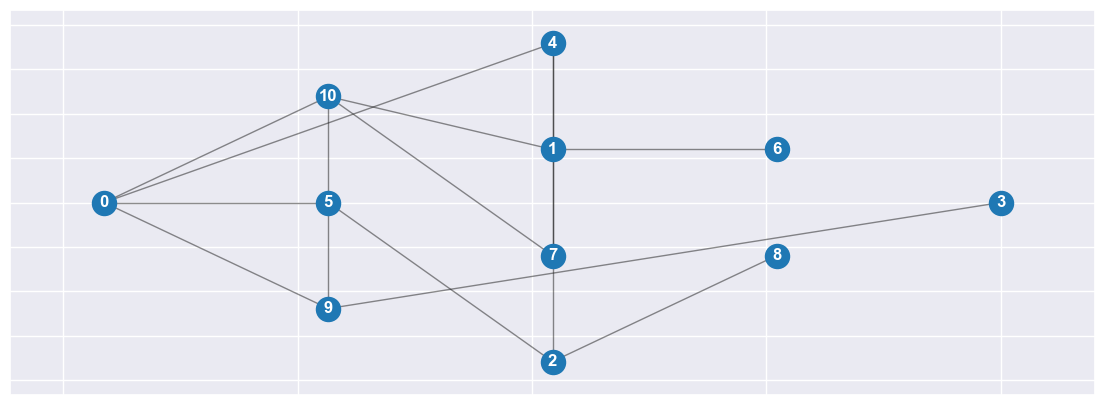




Original graph:
{0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]} [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]


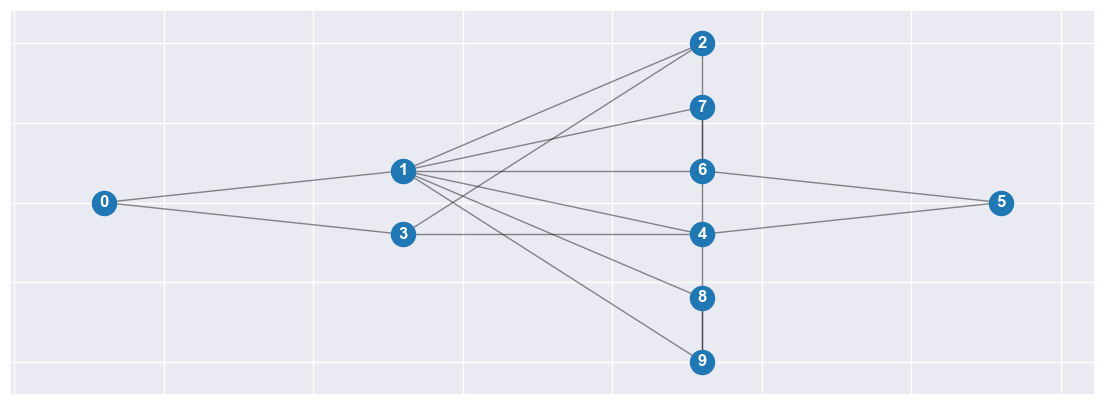

Answer graph:
{0: [0], 1: [3, 1], 2: [8, 9, 4, 2, 7, 6], 3: [5]}


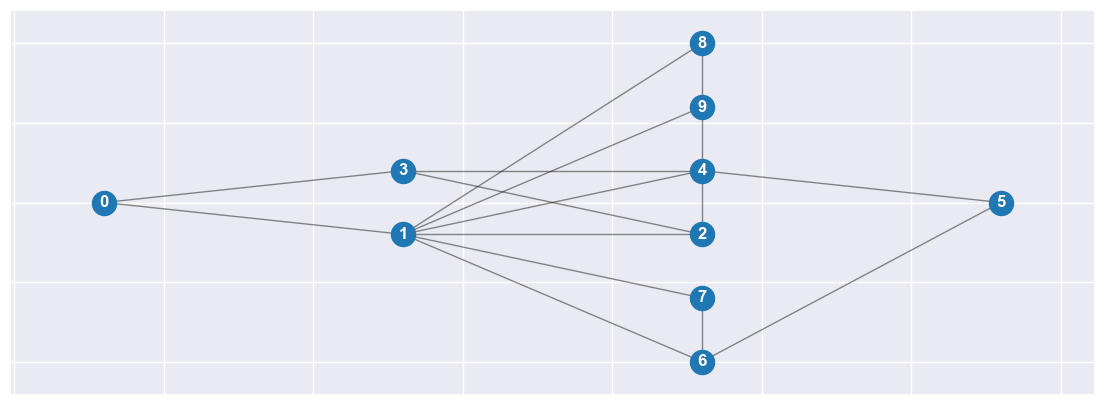




Original graph:
{0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]} [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]


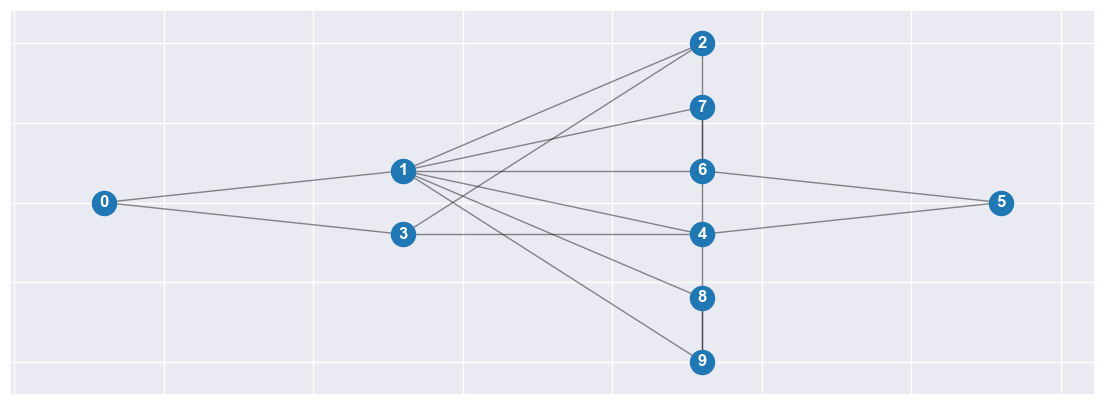

Answer graph:
{0: [0], 1: [1, 3], 2: [4, 6, 7, 8, 2, 9], 3: [5]}


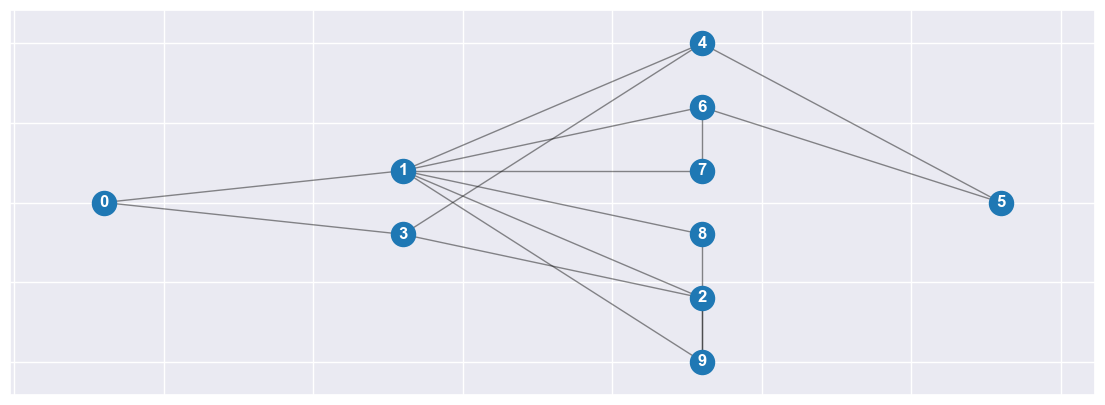




Original graph:
{0: [0], 1: [1, 7, 10], 2: [2, 4, 8, 9, 6], 3: [3, 5]} [(0, 1), (1, 2), (2, 3), (4, 5), (5, 6), (6, 7), (7, 1), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9), (7, 0), (10, 0), (10, 2), (10, 8)]


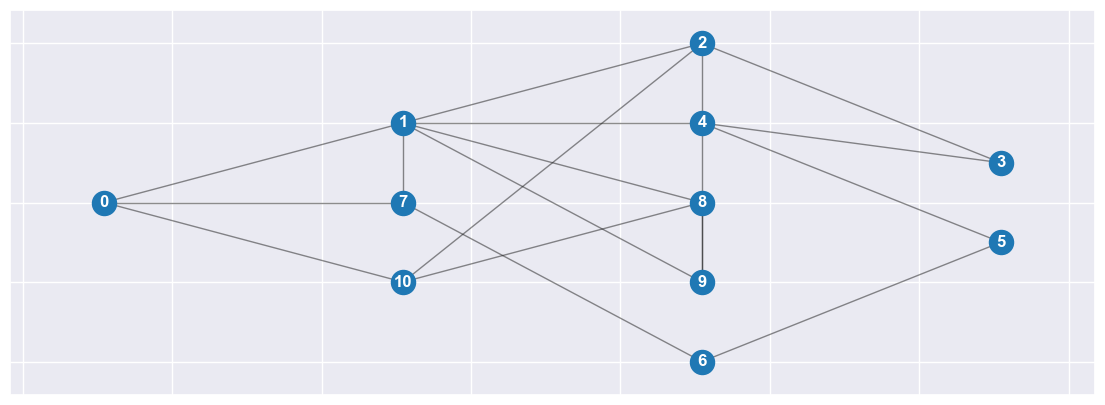

Answer graph:
{0: [0], 1: [1, 10, 7], 2: [2, 8, 9, 4, 6], 3: [3, 5]}


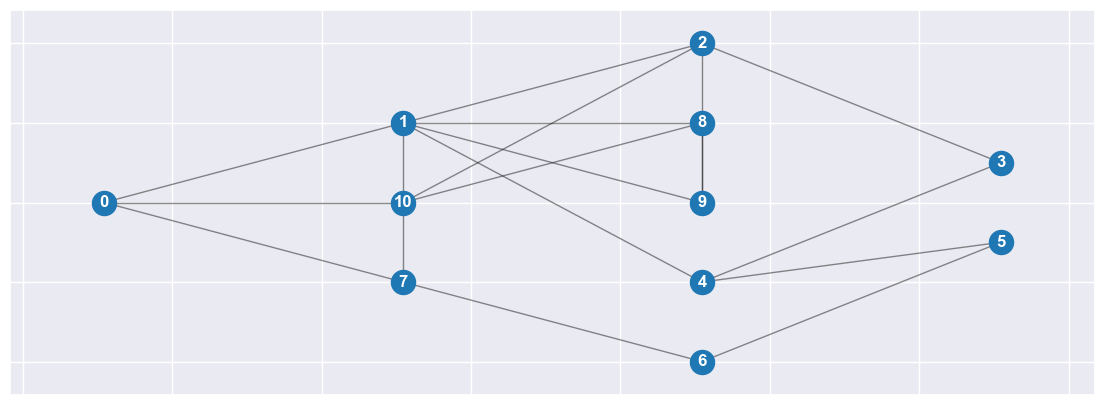




Original graph:
{0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]} [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]


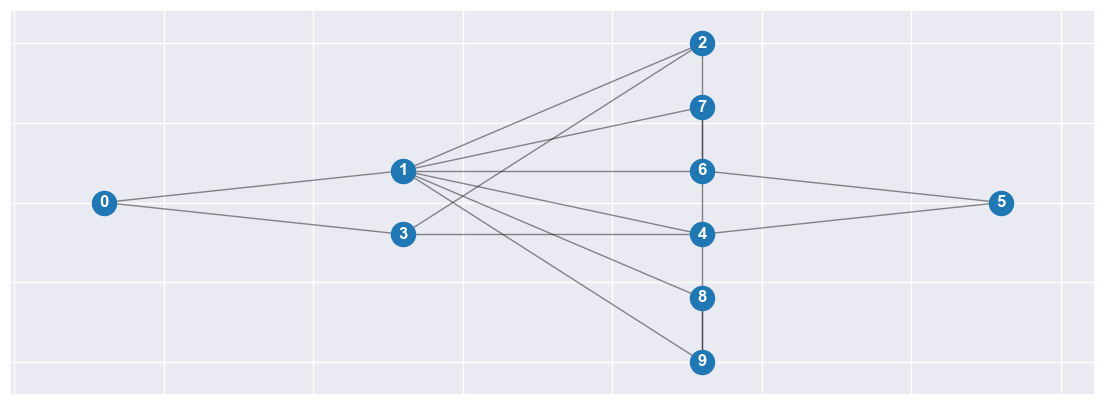

Answer graph:
{0: [0], 1: [3, 1], 2: [2, 6, 4, 7, 9, 8], 3: [5]}


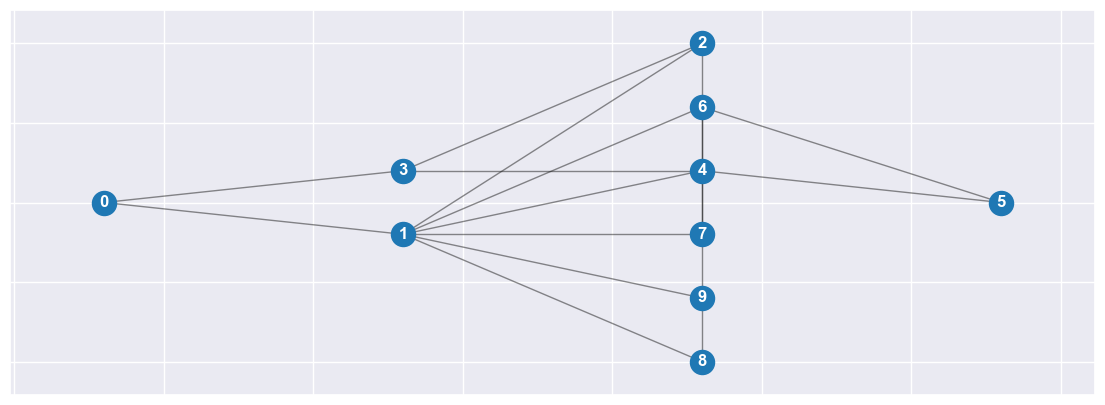




Original graph:
{0: [0], 1: [1, 3], 2: [2, 6, 4, 7, 8], 3: [10, 9, 5]} [(0, 1), (1, 2), (2, 3), (0, 3), (6, 1), (4, 1), (1, 7), (7, 8), (8, 1), (2, 8), (7, 5), (4, 9), (9, 5), (10, 6)]


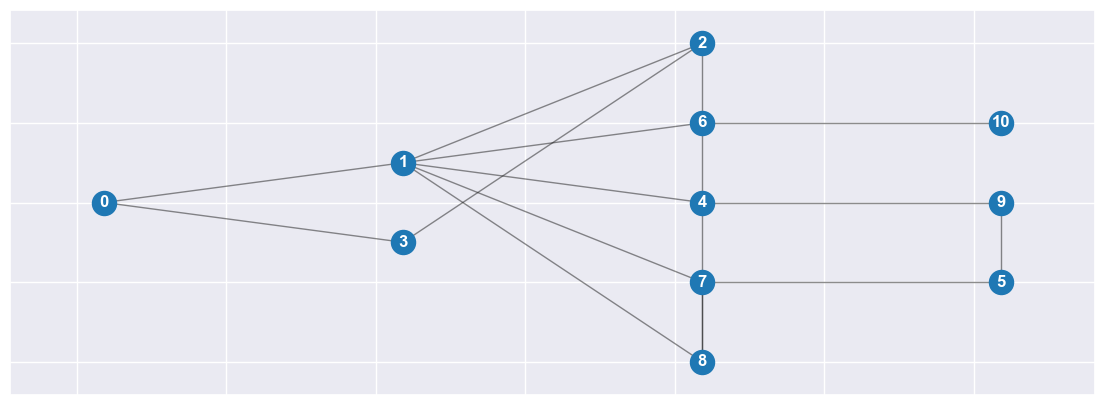

Answer graph:
{0: [0], 1: [1, 3], 2: [6, 2, 4, 8, 7], 3: [10, 9, 5]}


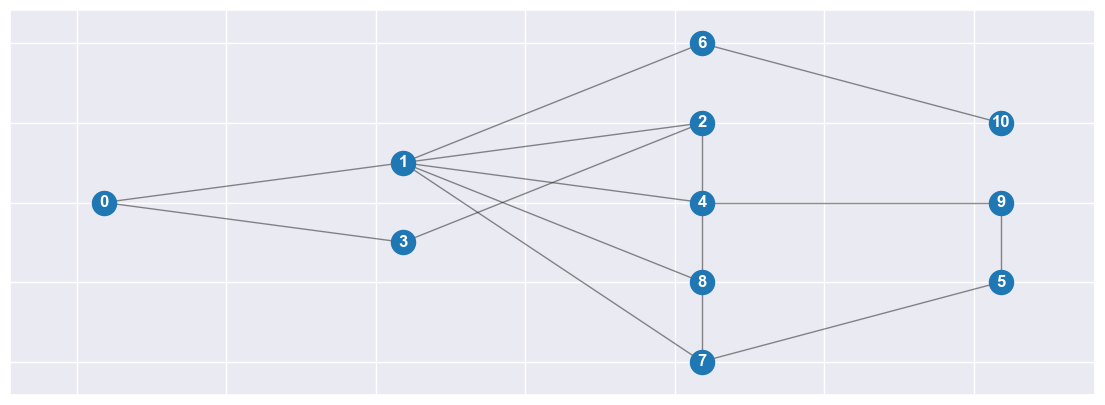




Original graph:
{0: [0], 1: [10], 2: [5, 3, 2, 6, 4, 1, 7], 3: [9, 8]} [(1, 6), (6, 2), (2, 7), (7, 3), (2, 8), (8, 4), (5, 6), (5, 9), (9, 1), (10, 5), (10, 3), (10, 2), (10, 6), (10, 4), (10, 1), (10, 0), (10, 7)]


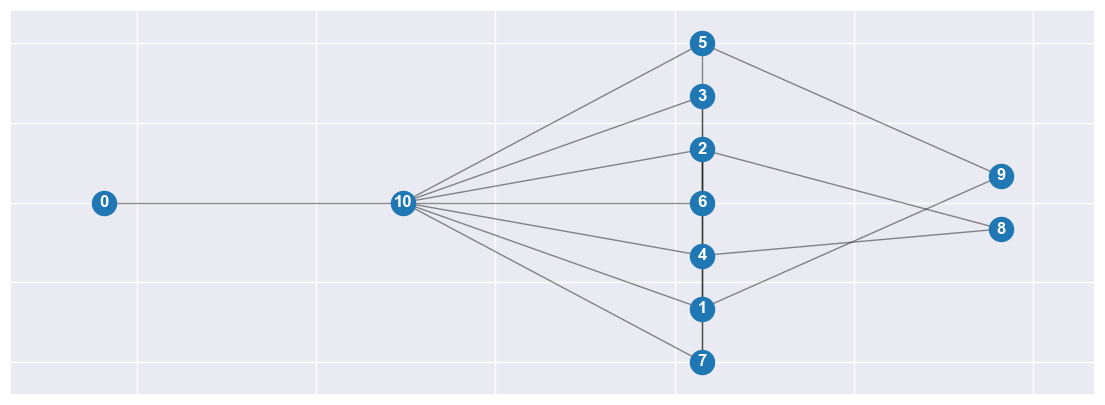

Answer graph:
{0: [0], 1: [10], 2: [5, 3, 2, 6, 1, 7, 4], 3: [9, 8]}


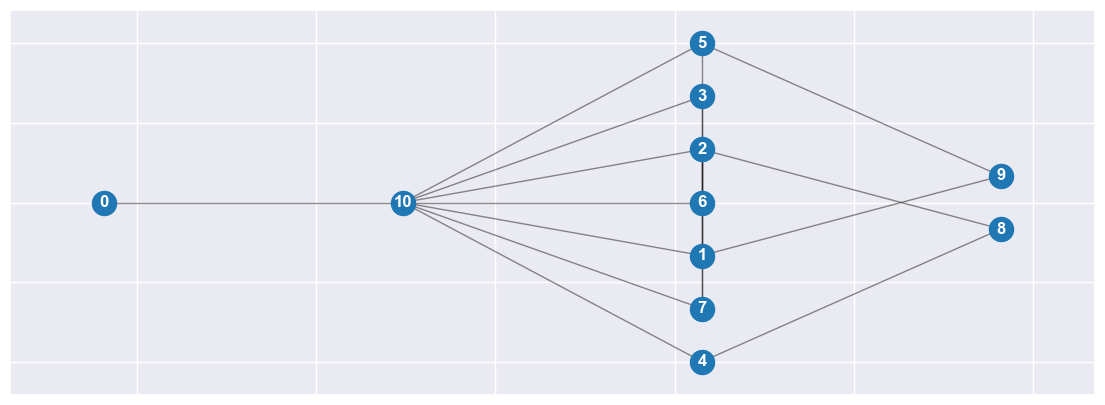




Original graph:
{0: [0], 1: [4, 5, 8], 2: [3, 1, 6, 7], 3: [9, 10, 2]} [(4, 0), (3, 5), (5, 0), (5, 1), (5, 6), (7, 2), (8, 3), (8, 0), (6, 9), (9, 3), (10, 3), (7, 5)]


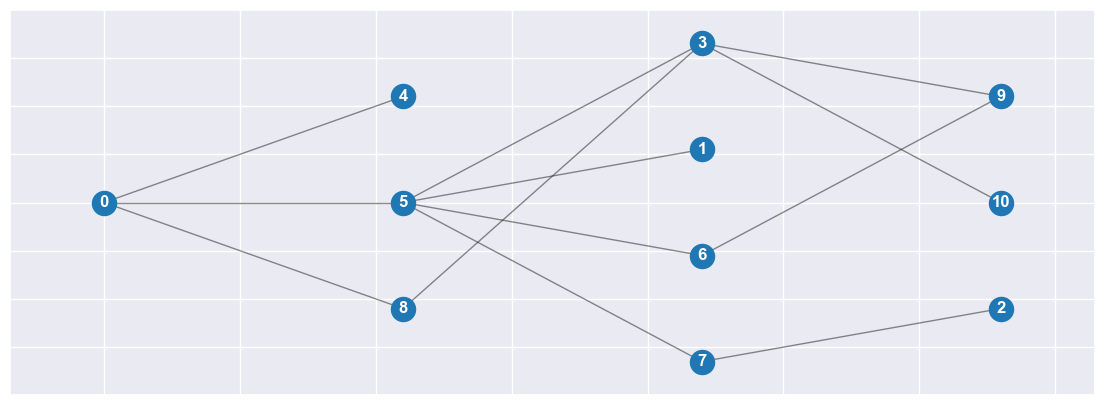

Answer graph:
{0: [0], 1: [8, 5, 4], 2: [7, 3, 1, 6], 3: [2, 10, 9]}


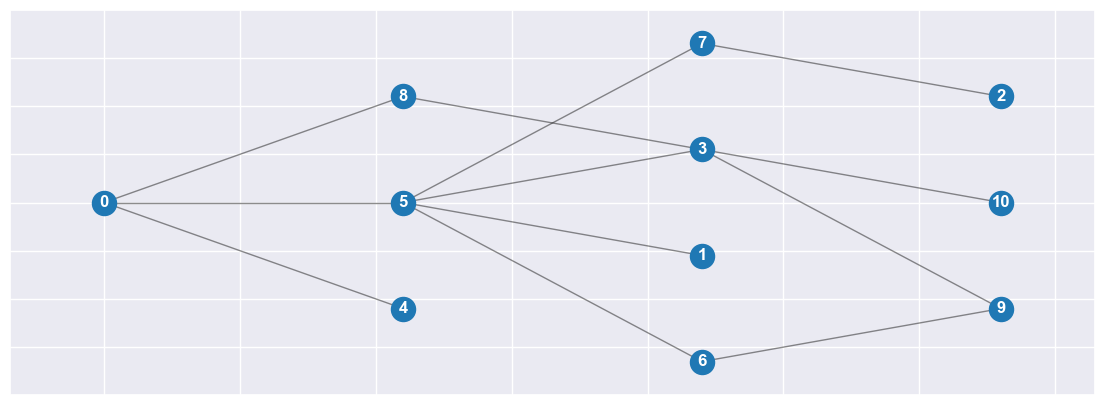




Original graph:
{0: [0], 1: [1], 2: [6, 8, 2, 9], 3: [3, 5, 4, 7], 4: [10]} [(5, 2), (1, 6), (6, 3), (0, 1), (2, 4), (7, 2), (8, 1), (8, 6), (2, 1), (1, 9), (9, 5), (10, 5), (10, 7)]


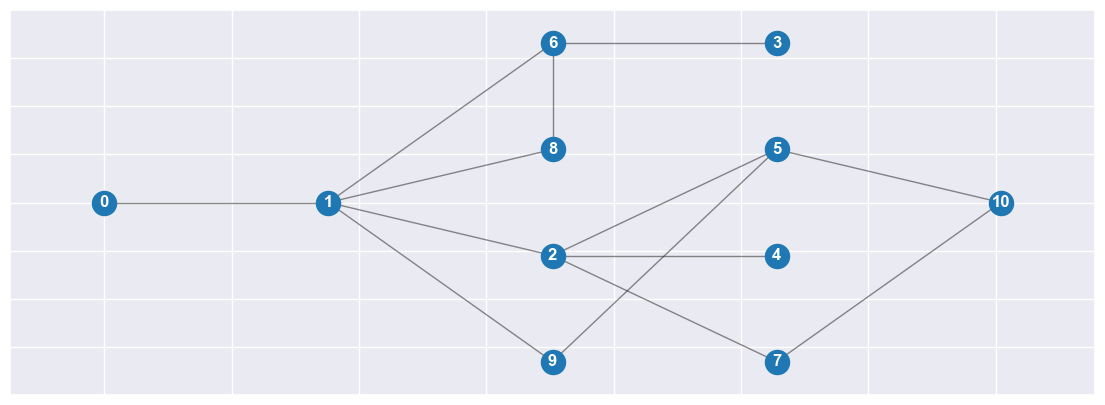

Answer graph:
{0: [0], 1: [1], 2: [6, 8, 9, 2], 3: [3, 5, 7, 4], 4: [10]}


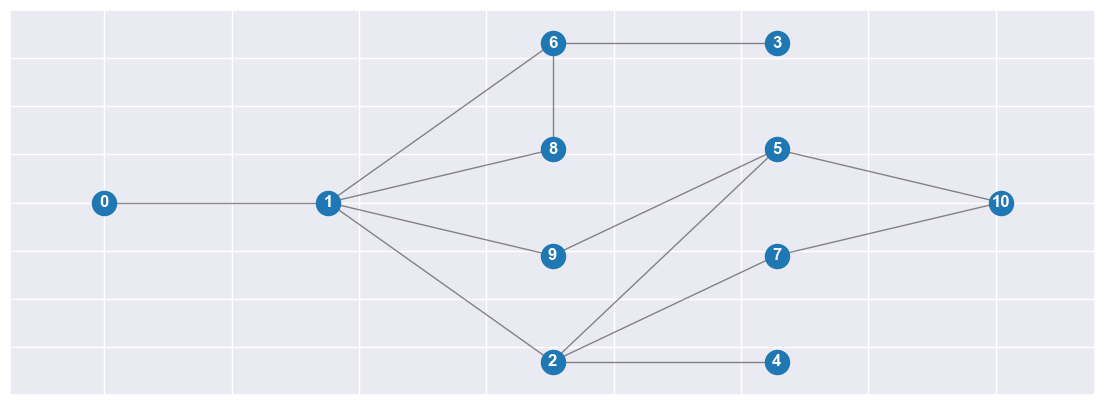




Original graph:
{0: [0], 1: [1, 3, 6], 2: [2, 5, 4, 7, 8], 3: [9]} [(0, 1), (1, 2), (2, 3), (0, 3), (5, 6), (6, 1), (1, 5), (4, 1), (4, 3), (1, 7), (0, 6), (8, 1), (9, 2), (5, 2)]


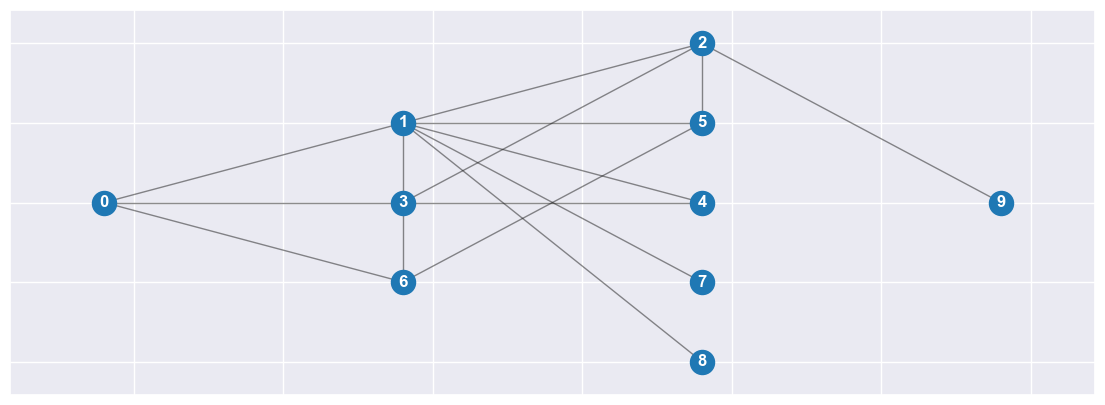

Answer graph:
{0: [0], 1: [1, 6, 3], 2: [2, 5, 7, 4, 8], 3: [9]}


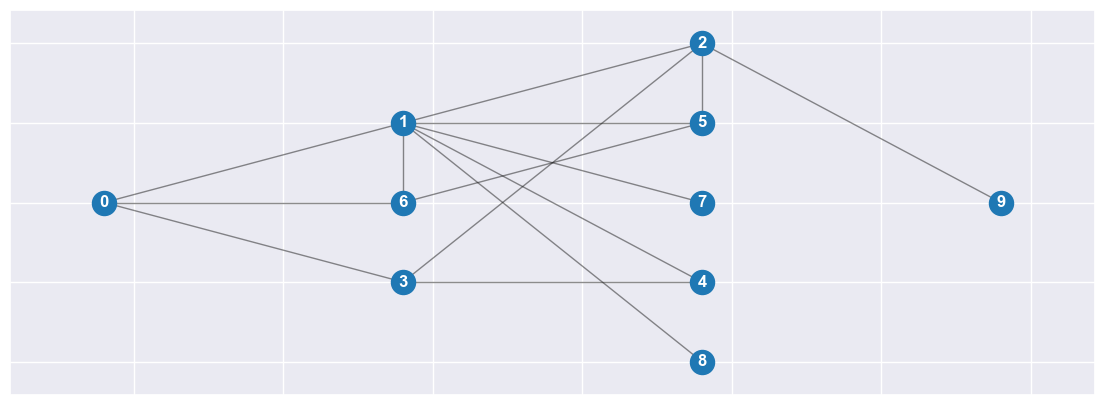




Original graph:
{0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]} [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]


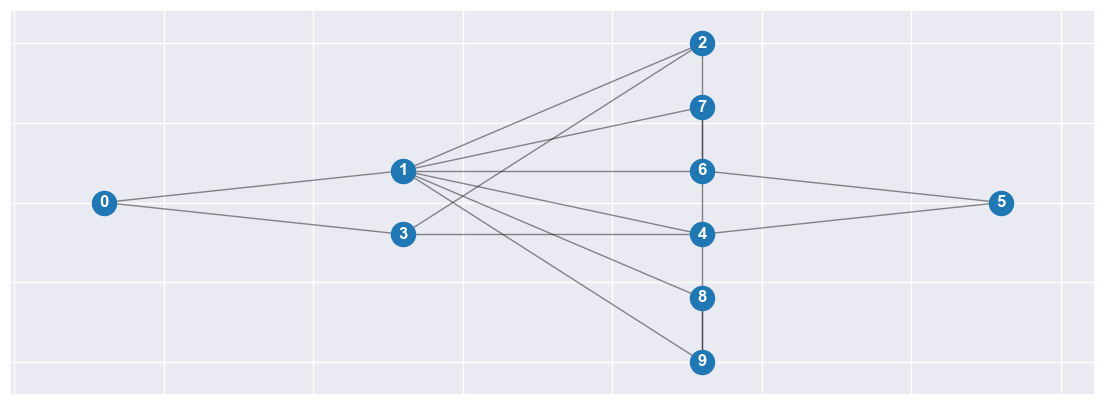

Answer graph:
{0: [0], 1: [3, 1], 2: [4, 6, 7, 2, 8, 9], 3: [5]}


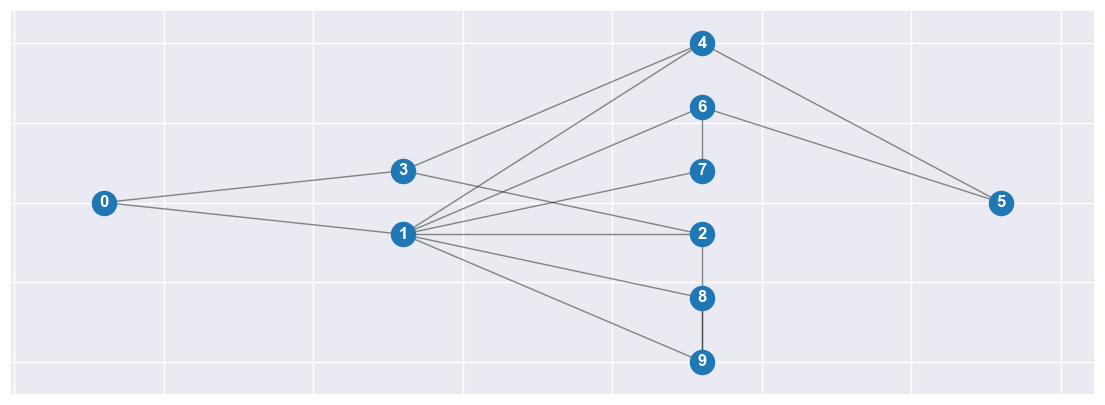




Original graph:
{0: [0], 1: [1, 3, 10], 2: [2, 7, 6, 4, 8], 3: [5, 9]} [(0, 1), (1, 2), (2, 3), (0, 3), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (8, 1), (2, 8), (2, 5), (5, 9), (9, 6), (10, 3), (10, 1), (10, 0)]


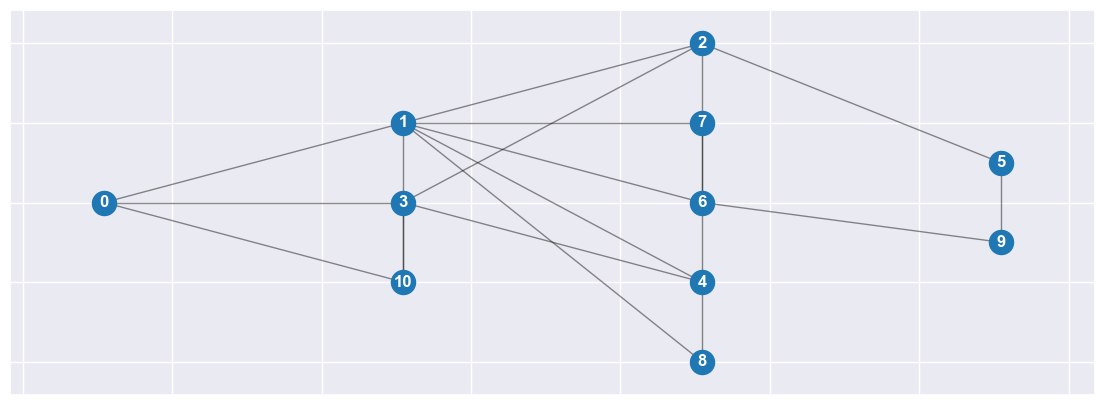

Answer graph:
{0: [0], 1: [1, 3, 10], 2: [7, 6, 2, 8, 4], 3: [5, 9]}


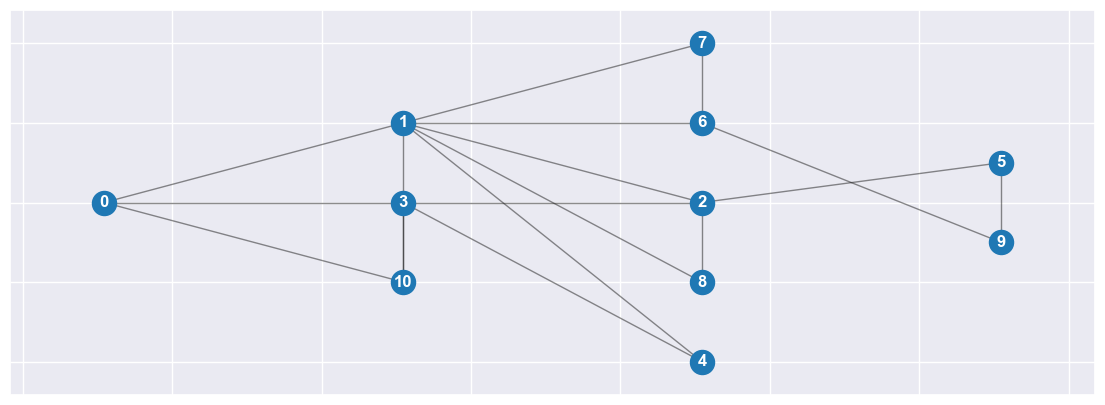




Original graph:
{0: [0], 1: [1, 2, 8], 2: [5, 6, 3, 7], 3: [9], 4: [4]} [(0, 1), (1, 2), (2, 3), (5, 1), (1, 6), (6, 7), (2, 7), (2, 0), (0, 8), (8, 3), (9, 4), (9, 5)]


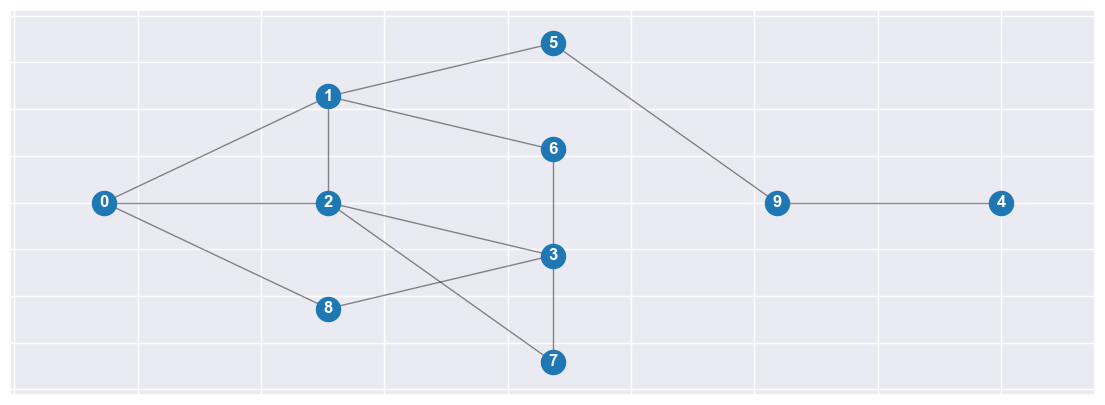

Answer graph:
{0: [0], 1: [1, 8, 2], 2: [5, 6, 3, 7], 3: [9], 4: [4]}


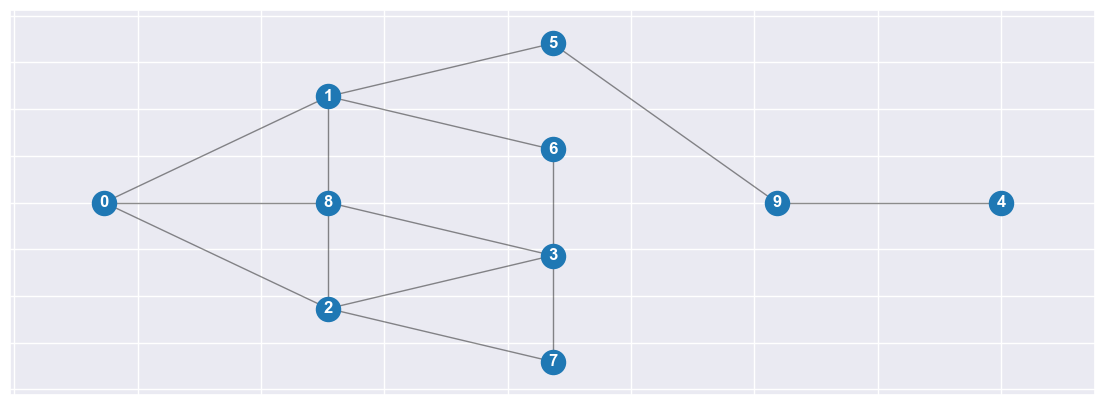

In [23]:
i = 0
for k in improved_answers:
    q_edges = queries[k["query"]]["edges"]
    q_ranks = queries[k["query"]]["ranks"]
    r = answers[k["query"]]
    print("Original graph:")
    print(q_ranks, q_edges)
    visualize_graph(q_ranks, q_edges)
    print("Answer graph:")
    print(r)
    visualize_graph(r, q_edges)
    print("\n\n")
    i += 1
    # if i == 1:
    #     break